In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

colname_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)
df.rename(columns=colname_dict, inplace=True)

In [3]:
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity',]
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi', 
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "Pheno Age Accel."]
for c in categorical_cols:
    df[c] = df[c].astype("category")
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats, dtype="category") # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats, dtype="category") # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [44]:
mean_std_dict

{'education (in years)': (12.883308270676691, 3.1342179862584296),
 'household wealth (ihs)': (5.4090805, 8.371072),
 'age': (70.04451127819549, 9.23433744595856),
 'bmi': (28.84815, 6.218937),
 'tract disadvantage': (-0.012159855, 0.94902503),
 'depressive symptoms': (1.3756391, 1.9412107),
 'adl limitations': (0.13142857, 0.5505619),
 'mean heat index over 7d': (74.170525, 18.664015),
 'pmono': (8.56896240601504, 2.425775207038868),
 'PNK_pct': (0.09263381460765885, 0.05817143127709421),
 'PBcell_pct': (0.06956864196926095, 0.05356930770984166),
 'PCD8_Plus_pct': (0.2503239019150917, 0.12165371343251581),
 'PCD4_Plus_pct': (0.6766124278740906, 0.13978046436234295),
 'PNCD8_Plus_pct': (0.22016338784150424, 0.15927694059686853),
 'Pheno Age Accel.': (-0.014999974, 0.99856097)}

In [5]:
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)', 
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_0. NHW', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_1. urban', 'urbanicity_2. suurban (code 2)',
'urbanicity_3. ex-urban', 'census division_Northeast',
'census division_Midwest', 'census division_South', 'census division_West']

### Prep data for train test split

In [6]:
# interactor
heat_cont_np = df_norm['mean heat index over 7d'].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["Pheno Age Accel."].to_numpy()

In [7]:
#dim reduction using PCA
k_dim = 28
U, S, V = torch.pca_lowrank(torch.from_numpy(interaction_vars_np), q=k_dim, center=False, niter=10)
V = V.to(torch.float32)
V.requires_grad = False

In [8]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3325


In [9]:
# split to train and test
train_idx, test_idx = train_test_split(num_elems, 0.7)
train_heat_cont = heat_cont_np[train_idx]
train_controlled_vars = controlled_vars_np[train_idx]
train_interaction_vars = interaction_vars_np[train_idx]
train_pheno_epi = pheno_epi_np[train_idx]

test_heat_cont = torch.from_numpy(heat_cont_np[test_idx].astype(np.float32))
test_controlled_vars = torch.from_numpy(controlled_vars_np[test_idx].astype(np.float32))
test_interaction_vars = torch.from_numpy(interaction_vars_np[test_idx].astype(np.float32))
test_pheno_epi = torch.from_numpy(pheno_epi_np[test_idx].astype(np.float32))

In [10]:
# create dataset
train_dataset = MIHMDataset(train_heat_cont, train_controlled_vars, train_interaction_vars, train_pheno_epi)
dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

### Train

In [22]:
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import AdamW
import pyro
from mihm.model.bayes_mihm import BayesMIHM

In [23]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = BayesMIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
                  svd=True, svd_matrix=V, k_dim=k_dim, include_interactor_bias=True)

In [24]:
guide = AutoMultivariateNormal(model)

In [45]:
optim = AdamW({"lr": 0.01, "weight_decay": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
epochs = 500
mseLoss = nn.MSELoss()
torch.manual_seed(0)

In [46]:
from pyro.infer import Predictive
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [47]:
def get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi, n_samples=100):
    model.eval()
    predictive = Predictive(model, guide=guide, num_samples=n_samples,
                    return_sites=("obs", "_RETURN"))
    samples = predictive(test_interaction_vars, test_heat_cont, test_controlled_vars,)
    pred_summary = summary(samples)
    predicted_epi = pred_summary["_RETURN"]["mean"]        
    loss_test = mseLoss(predicted_epi, test_pheno_epi)
    return loss_test.item(), pred_summary

In [48]:
for epoch in range(epochs):
    loss = 0
    for batch_idx, sample in enumerate(dataloader):
        loss += svi.step(sample["interaction_input_vars"], sample["interactor_var"], sample["controlled_vars"], y=sample["label"])
    loss /= len(dataloader.dataset)
    print(f"Epoch {epoch+1} : loss = {loss}")
    test_loss, _ = get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi)
    print(f"Test loss: {test_loss}")

Epoch 1 : loss = 700.2759154139525
Test loss: 1.0426138639450073


Using a target size (torch.Size([998])) that is different to the input size (torch.Size([998, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 2 : loss = 697.8328615586114
Test loss: 1.0431760549545288
Epoch 3 : loss = 701.4760586382869
Test loss: 1.041725516319275
Epoch 4 : loss = 703.8959519494506
Test loss: 1.044853925704956
Epoch 5 : loss = 695.6628431087647
Test loss: 1.0434999465942383
Epoch 6 : loss = 701.3704334979402
Test loss: 1.0446388721466064
Epoch 7 : loss = 697.2076550216134
Test loss: 1.0420302152633667
Epoch 8 : loss = 699.3582324453586
Test loss: 1.0414972305297852
Epoch 9 : loss = 721.5545997466198
Test loss: 1.0433738231658936
Epoch 10 : loss = 715.249593532346
Test loss: 1.0424617528915405
Epoch 11 : loss = 705.6950545116481
Test loss: 1.0437018871307373
Epoch 12 : loss = 705.4313549339646
Test loss: 1.043114185333252
Epoch 13 : loss = 715.6879642294375
Test loss: 1.0425989627838135
Epoch 14 : loss = 701.6435153149021
Test loss: 1.0419034957885742
Epoch 15 : loss = 705.6271599512987
Test loss: 1.044709324836731
Epoch 16 : loss = 709.3337662099166
Test loss: 1.043866515159607
Epoch 17 : loss = 720.00

In [29]:
print("interaction_weight:", model.interaction_weight)

interaction_weight: tensor([0.0154])


In [30]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

layers$$$0.weight Parameter containing:
tensor([[ 0.0879, -0.0795, -0.0713,  ...,  0.0830, -0.0292, -0.1437],
        [-0.0665,  0.0020,  0.0241,  ...,  0.0679,  0.0028,  0.0330],
        [-0.1027,  0.1002,  0.0340,  ...,  0.0068,  0.0422, -0.1187],
        ...,
        [ 0.0308,  0.0124, -0.0064,  ..., -0.1626,  0.0877, -0.0986],
        [-0.0658,  0.1281,  0.1041,  ...,  0.0923,  0.0540,  0.1728],
        [ 0.0401,  0.0166, -0.1117,  ..., -0.0453, -0.1539, -0.0250]],
       requires_grad=True)
layers$$$0.bias Parameter containing:
tensor([-0.0199, -0.1239, -0.0719,  0.0301, -0.0312,  0.0014, -0.0255, -0.0058,
         0.1239, -0.0707,  0.1327, -0.0501,  0.1292,  0.0216, -0.0376,  0.0292,
         0.0360, -0.1025, -0.0504, -0.0421,  0.1385, -0.0576,  0.0381, -0.0163,
         0.0325, -0.0649, -0.0053,  0.0443, -0.0641, -0.0050, -0.0280,  0.0204,
        -0.0540,  0.0706, -0.0789, -0.0076,  0.0686, -0.0269,  0.0303, -0.0113,
         0.0656,  0.1138,  0.0264,  0.0350, -0.0817,  0.0469,

In [ ]:
# model = BayesMIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
#                     svd=True, svd_matrix=V, k_dim=k_dim)
# state_dict = torch.load('../checkpoints/{}.pth'.format("Feb14_heat_model_bnn_linear_svd"))

In [31]:
# model.load_state_dict(state_dict)
model.eval()

BayesMIHM(
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (controlled_var_weights): PyroLinear(in_features=37, out_features=1, bias=True)
)

In [32]:
import matplotlib.pyplot as plt

In [33]:
_, pred_summary = get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi, n_samples=1000)

In [34]:
all_interaction_vars_tensor = torch.from_numpy(interaction_vars_np.astype(np.float32))
model.eval()
predicted_index = model.get_resilience_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().numpy()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   2.,   3.,   1.,   1.,   6.,   9.,   8.,  13.,  17.,  19.,
         21.,  40.,  55.,  52.,  57.,  78., 115., 116., 151., 155., 198.,
        187., 197., 234., 271., 229., 210., 217., 168., 130., 120., 105.,
         62.,  34.,  18.,  11.,  11.,   1.]),
 array([-4.69040453e-01, -4.58847195e-01, -4.48653936e-01, -4.38460708e-01,
        -4.28267449e-01, -4.18074191e-01, -4.07880932e-01, -3.97687674e-01,
        -3.87494415e-01, -3.77301186e-01, -3.67107928e-01, -3.56914669e-01,
        -3.46721411e-01, -3.36528152e-01, -3.26334894e-01, -3.16141665e-01,
        -3.05948406e-01, -2.95755148e-01, -2.85561889e-01, -2.75368631e-01,
        -2.65175372e-01, -2.54982144e-01, -2.44788870e-01, -2.34595627e-01,
        -2.24402368e-01, -2.14209110e-01, -2.04015866e-01, -1.93822607e-01,
        -1.83629364e-01, -1.73436105e-01, -1.63242847e-01, -1.53049603e-01,
        -1.42856345e-01, -1.32663086e-01, -1.22469

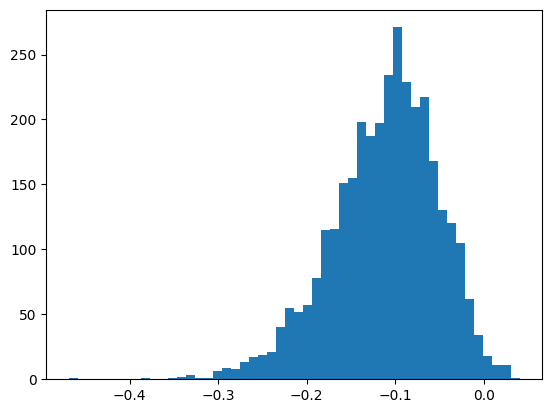

In [35]:
plt.hist(all_resilience_index, bins=50)

In [36]:
torch.save(model.state_dict(), "../checkpoints/Feb26_heat_model_with_heat_bias_max.pth")

### Shapley Analysis

In [37]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [38]:
model_name = "Feb26_heat_model_with_heat_bias_max"

In [39]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model_index = IndexPredictionModel(interaction_var_size, hidden_layer_sizes, 
                             svd=True, svd_matrix=V.cuda(), k_dim=k_dim)

In [40]:
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
state_dict_index = get_index_prediction_weights(state_dict)
model_index.load_state_dict(state_dict_index)
model_index.cuda().eval()

IndexPredictionModel(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [41]:
interaction_vars_torch = torch.from_numpy(interaction_vars_np.astype('float32')).cuda()
explainer = shap.DeepExplainer(model_index, interaction_vars_torch)

In [42]:
shap_values = explainer.shap_values(interaction_vars_torch[:1000], check_additivity=False)

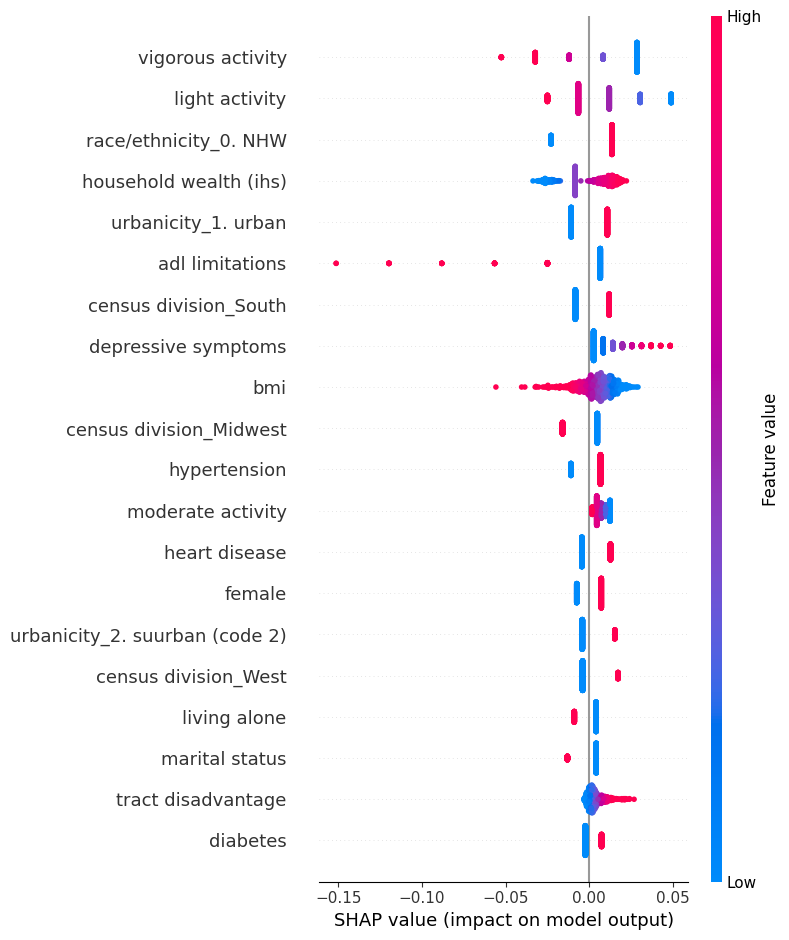

In [43]:
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/{}_1.png".format(model_name), dpi=300, bbox_inches="tight")

In [ ]:
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
print(state_dict.keys())

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.1.bias', 'layers.2.weight', 'layers.2.bias'])
